Cluster students by skill level.

Inputs:

- gradebook data (formative assessments)
- assignment weight (100 - median grade)

Outputs:

- plot students in latent space
- kmeans clusters

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
import string
import itertools

%matplotlib inline

,Student ID,Gender,Age,Race/Ethnicity,SPED Status,Quiz 1,Quiz 2,Quiz 3,Final Grade
0,72176,M,17,Black or African American,No,64.287292,87.376920,77.520208,76.394807
1,70630,F,16,Two or more races,No,58.523741,73.092707,72.518534,68.044994
2,27613,F,17,White,No,45.670402,59.652601,94.012994,66.445332
3,40137,M,16,Hispanic/Latino,Yes,65.115976,72.816634,98.759864,78.897491
4,93131,M,15,Two or more races,No,80.811121,19.236592,82.423491,60.823734


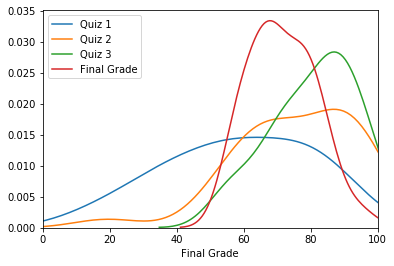

In [381]:
# 1. Simulate Data

def simulate_grades(mu, sigma, n_students):
    grades = []
    for i in range(n_students):
        g = -1
        while g<0 or g>100:
            g = np.random.normal(mu, sigma)
        grades.append(g)
    return grades


def simulate_gradebook(n_students=20):
    gb =  pd.DataFrame({'Student ID': np.random.choice(100000, n_students, replace=False),
                        'Gender': np.random.choice(['M', 'F'], n_students),
                        'Age': np.random.choice([15, 16, 16, 17], n_students),
                        'Race/Ethnicity': np.random.choice(['Hispanic/Latino', 'American Indian or Alaska Native',
                                                            'Asian', 'Black or African American',
                                                            'Native Hawaiian or Other Pacific Islander', 'White',
                                                            'Two or more races'], n_students),
                        'SPED Status': np.random.choice(['No', 'Yes'], n_students, p=[0.8, 0.2]),
                        'Quiz 1': simulate_grades(70, 30, n_students), #simulate_grades(mu, sigma, n_students)
                        'Quiz 2': simulate_grades(80, 25, n_students),
                        'Quiz 3': simulate_grades(90, 20, n_students)})
    gb['Final Grade'] = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean(axis='columns')
    return gb

gb = simulate_gradebook(30)
display(gb.head())

for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    sns.distplot(gb[col], hist=False, label=col)
plt.legend()
plt.xlim([0,100])
plt.show()

In [382]:
# 2. Cluster
n_clusters=4

# K-Means
kmeans = KMeans(n_clusters).fit(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['kmeans'] = [string.ascii_uppercase[i] for i in kmeans.labels_]

# Gaussian Mixture Model
gm = GaussianMixture(n_clusters, n_init=100).fit(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['gaussmix'] = gm.predict(gb[['Quiz 1', 'Quiz 2', 'Quiz 3']])
gb['gaussmix'] = gb['gaussmix'].map(lambda i: string.ascii_uppercase[i])

# comparison of mappings
display(gb.groupby(['kmeans', 'gaussmix']).size())

kmeans  gaussmix
A       C            2
        D            2
B       A           12
C       B            4
D       B           10
dtype: int64

In [389]:
sns.color_palette('RdYlGn_r')

[(0.22468281430219147, 0.6558246828143022, 0.3444059976931949),
 (0.6165321030372932, 0.835909265667051, 0.41191849288735105),
 (0.8918877354863514, 0.954479046520569, 0.6010765090349866),
 (0.9971549404075356, 0.9118031526336026, 0.6010765090349867),
 (0.9873125720876587, 0.6473663975394082, 0.36424452133794705),
 (0.8899653979238754, 0.28673587081891583, 0.19815455594002307)]

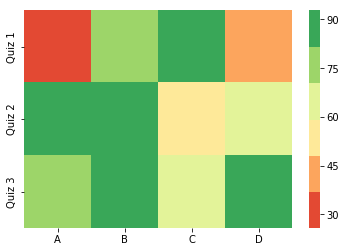

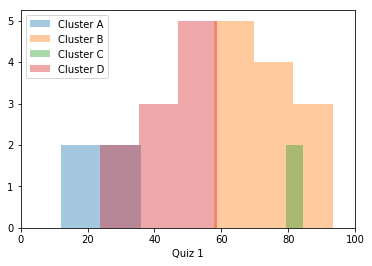

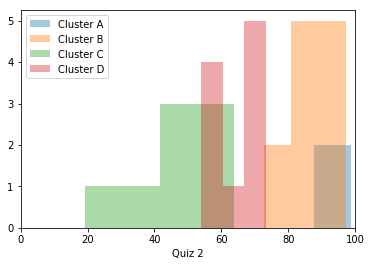

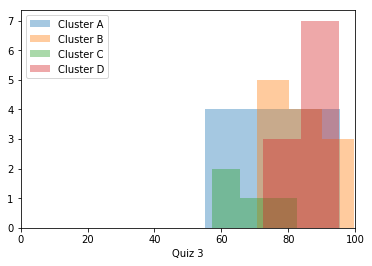

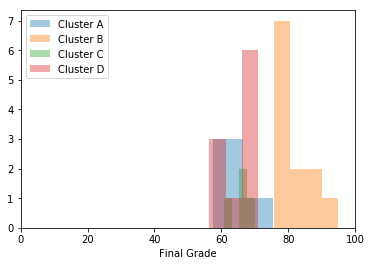

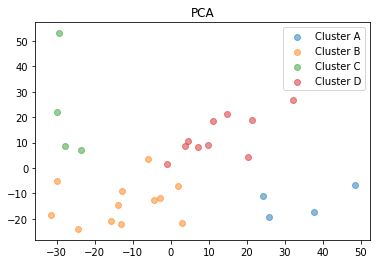

explained variance ratio: 83.7% explained [0.49799187 0.33880375]


In [398]:
# 3. Visualize Clusters

cluster_method = 'kmeans'

# K-Means
sns.heatmap(kmeans.cluster_centers_.T, cmap=sns.color_palette('RdYlGn_r')[::-1])
plt.xticks(np.arange(n_clusters)+0.5, string.ascii_uppercase[:n_clusters])
plt.yticks(np.arange(3)+0.5, ['Quiz 1', 'Quiz 2', 'Quiz 3'], verticalalignment='center')
plt.show()


# Gaussiam Mixture Model
for col in ['Quiz 1', 'Quiz 2', 'Quiz 3', 'Final Grade']:
    for i in string.ascii_uppercase[:n_clusters]:
        sns.distplot(gb.loc[gb[cluster_method]==i, col], kde=False, label=f'Cluster {i}')
    plt.legend()
    plt.xlim([0,100])
    plt.show()
    

# PCA
X = gb[['Quiz 1', 'Quiz 2', 'Quiz 3']]
y = gb[cluster_method]
cluster_labels = gb[cluster_method].drop_duplicates().sort_values().values
target_names = cluster_labels

pca = PCA(n_components=2)
X_reduced = pca.fit(X).transform(X)

for i, target_name in zip(cluster_labels, target_names):
    plt.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], label=f'Cluster {target_name}', alpha=0.5)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

# Percentage of variance explained for each components
print('explained variance ratio: {}% explained {}'
      .format(round(sum(pca.explained_variance_ratio_), 3)*100, pca.explained_variance_ratio_))

Group A: 56340, 22891, 8163, 69028
Group B: 72176, 40137, 14684, 85092, 15753, 12755, 86191, 32452, 37223, 83997, 76781, 76340
Group C: 93131, 32867, 15752, 4924
Group D: 70630, 27613, 7353, 59924, 83662, 53748, 32994, 21490, 86364, 562


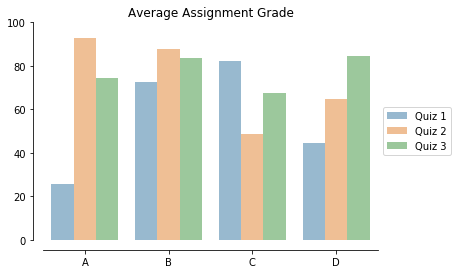

Recommendations:
Group A should focus on Quiz 1
Group B should focus on Quiz 1
Group C should focus on Quiz 2
Group D should focus on Quiz 1


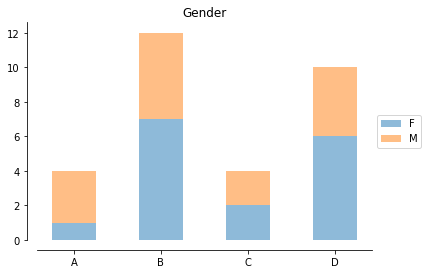

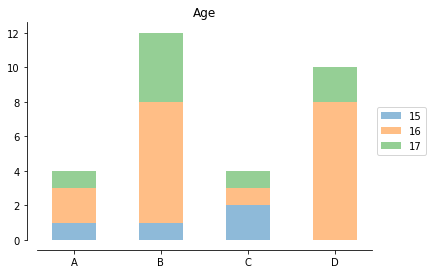

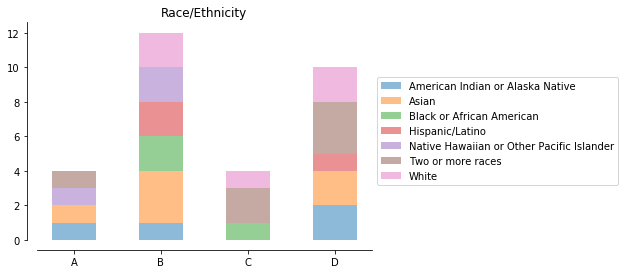

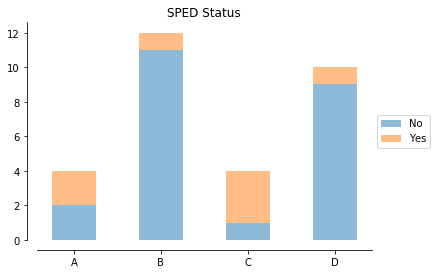

In [388]:
# 4. Describe Clusters and Offer Recommendations

# which students are in which group?
for label in string.ascii_uppercase[:n_clusters]:
    print(f"Group {label}: {', '.join(gb.loc[gb[cluster_method]==label, 'Student ID'].astype(str).values)}")

# average scores by cluster
palette = sns.color_palette()
temp = gb.groupby(cluster_method)[['Quiz 1', 'Quiz 2', 'Quiz 3']].mean()
recommendations = pd.DataFrame(temp.apply(lambda x: temp.columns[x.values.argmin()], axis='columns'))
temp = temp.stack().reset_index().rename({'level_1':'quiz', 0:'grade', cluster_method:'cluster'}, axis='columns')
b = sns.barplot('cluster', 'grade', 'quiz', data=temp, alpha=0.5, palette=palette)
sns.despine(offset=10, trim=False)
b.legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,100])
plt.xlabel('')
plt.ylabel('')
plt.title('Average Assignment Grade')
plt.show()

# which assignment does each group need to focus on?
print('Recommendations:')
for label in recommendations.index:
    print(f'Group {label} should focus on {recommendations.loc[label].values[0]}')

    
# similarities and differences on other characteristics (gender, age, race, SPED)
for field in ['Gender', 'Age', 'Race/Ethnicity', 'SPED Status']:
    temp = gb.groupby([cluster_method, field]).size()
    temp = temp.reindex(pd.MultiIndex.from_product(temp.index.levels),
                        fill_value=0.0)\
                .reset_index()\
                .rename({'level_0':'cluster', 'level_1':field, 0:'count'}, axis='columns')
    temp['count'] = temp['count'].astype(int)
    values = temp[field].drop_duplicates()
    palette = itertools.cycle(sns.color_palette())
    bottom = np.zeros(n_clusters)
    plots = []
    for i, value in enumerate(values):
        g = plt.bar(temp.loc[temp[field]==value, 'cluster'],
                temp.loc[temp[field]==value, 'count'],
                width=0.5, alpha=0.5, color=next(palette),
                bottom=bottom)
        plots.append(g)
        bottom = np.add(bottom, temp.loc[temp[field]==value, 'count'])
    sns.despine(offset=10, trim=False)
    plt.legend(plots, values, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(field)
    plt.show()